In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

from glob import glob

%matplotlib inline

In [2]:
IMG_SIZE = 192

In [3]:
images = np.array([cv2.resize(cv2.imread(i),(IMG_SIZE,IMG_SIZE)) for i in glob("leedsbutterfly\\images/*")])
masks = np.array([cv2.resize(cv2.imread(i),(IMG_SIZE,IMG_SIZE)) for i in glob("leedsbutterfly\\segmentations/*")])

In [4]:
images = images / 255
masks = masks / 255

In [5]:
masks_bin = (masks.mean(axis=3).reshape(-1,IMG_SIZE,IMG_SIZE,1) > 0.).astype(np.uint8)

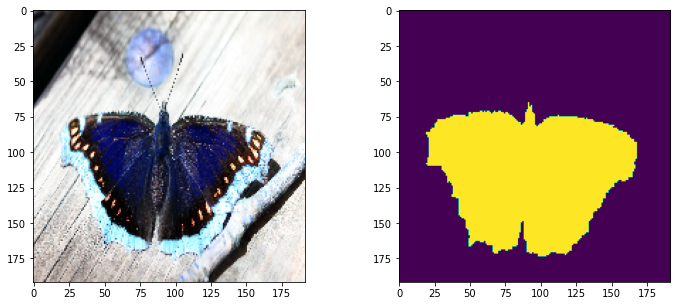

In [6]:
i = np.random.randint(len(images))
img,mask = images[i].copy(),masks_bin[i].copy()

fig,axes = plt.subplots(1,2,figsize=(12,5))
axes[0].imshow(img)
axes[1].imshow(mask.reshape(IMG_SIZE,IMG_SIZE))

In [7]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.layers import *

In [17]:
inp = Input(shape=images[0].shape)

conv = Conv2D(32,3,activation="relu",padding="same")(inp)
conv = Conv2D(32,3,activation="relu",padding="same")(conv)
batch = BatchNormalization()(conv)
pool = MaxPool2D()(batch)

conv = Conv2D(64,3,activation="relu",padding="same")(pool)
conv = Conv2D(64,3,activation="relu",padding="same")(conv)
batch = BatchNormalization()(conv)
pool = MaxPool2D()(batch)

conv = Conv2D(128,3,activation="relu",padding="same")(pool)
conv = Conv2D(128,3,activation="relu",padding="same")(conv)
batch = BatchNormalization()(conv)
pool = MaxPool2D()(batch)

conv = Conv2D(256,1,activation="relu",padding="same")(pool)
pool = MaxPool2D()(conv)
neck = Flatten()(pool)
neck = Dense(1024,activation="relu")(neck)
neck = Dense(36864,activation="relu")(neck)
neck = tf.reshape(neck,(-1,12,12,256))
convt = Conv2DTranspose(256,1,activation="relu",strides=2,padding="same")(neck)

convt = Conv2DTranspose(128,3,activation="relu",padding="same")(convt)
convt = Conv2DTranspose(128,3,activation="relu",strides=2,padding="same")(convt)
batch = BatchNormalization()(convt)

convt = Conv2DTranspose(64,3,activation="relu",padding="same")(batch)
convt = Conv2DTranspose(64,3,activation="relu",strides=2,padding="same")(convt)
batch = BatchNormalization()(convt)

convt = Conv2DTranspose(32,3,activation="relu",strides=2,padding="same")(batch)
convt = Conv2DTranspose(32,3,activation="relu",padding="same")(convt)
batch = BatchNormalization()(convt)

convt = Conv2DTranspose(3,3,activation="relu",strides=2,padding="same")(batch)
out = Conv2D(1,1,strides=2,padding="same",activation="sigmoid")(convt)

model = keras.Model(inp,out,name="conv_auto_encoder")

In [18]:
model.summary()

Model: "conv_auto_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 192, 192, 3)]     0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 192, 192, 32)      896       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 192, 192, 32)      9248      
_________________________________________________________________
batch_normalization_6 (Batch (None, 192, 192, 32)      128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 96, 96, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 96, 96, 64)        18496     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 96, 96, 64)  

In [19]:
index =  np.arange(0,len(images))
np.random.shuffle(index)

X,Y = images[index],masks_bin[index]

In [20]:
model.compile(optimizer="adam",loss="binary_crossentropy")

In [21]:
grid = [
    [8,10],
    [4,10],
    [2,15],
    [1,15]
]

In [22]:
model_checkpoint = keras.callbacks.ModelCheckpoint(
        filepath="checkpoints/conv_auto_encoder",
        save_weights_only=True,
        monitor='loss',
        save_best_only=True,
    )

In [23]:
class SaveEpoch(keras.callbacks.Callback):
    def __init__(self,base):
        self.base = base
        
    def on_epoch_end(self,epoch,log, **kwargs):
        fig,axes = plt.subplots(1,3,figsize=(15,6))
        fig.suptitle(f"Epoch : {self.base + epoch} | Loss : {log['loss']}")
        img = images[0:1].copy()
        mask = masks_bin[0].copy()
        pred = self.model.predict(img)
        
        axes[0].imshow(img[0])
        axes[0].axis("off")
        axes[0].set_title("Image")
        
        axes[1].imshow(mask.reshape(IMG_SIZE,IMG_SIZE),cmap="gray")
        axes[1].axis("off")
        axes[1].set_title("Ground Truth")
        
        axes[2].imshow(pred.reshape(IMG_SIZE,IMG_SIZE),cmap="gray")
        axes[2].axis("off")
        axes[2].set_title("Predicted Mask")
        
        fig.savefig(f"doc/epochs/{self.base + epoch}.jpg")
        plt.close();

In [24]:
alpha_c = np.ones((IMG_SIZE,IMG_SIZE,3)) * np.array([1,0,0])

In [25]:
hist = []
saveepoch = SaveEpoch(0)

for batch_size,epochs in grid:
    history = model.fit(X,Y,batch_size=batch_size,epochs=epochs,callbacks=[model_checkpoint,saveepoch])
    hist.append(history)
    saveepoch.base += epochs

Train on 832 samples
Epoch 1/10
832/832 [==============================] - 23s 28ms/sample - loss: 0.3618
Epoch 2/10
832/832 [==============================] - 21s 25ms/sample - loss: 0.2674
Epoch 3/10
832/832 [==============================] - 24s 28ms/sample - loss: 0.2236
Epoch 4/10
832/832 [==============================] - 25s 30ms/sample - loss: 0.1914
Epoch 5/10
832/832 [==============================] - 26s 31ms/sample - loss: 0.1690
Epoch 6/10
832/832 [==============================] - 25s 30ms/sample - loss: 0.1544
Epoch 7/10
832/832 [==============================] - 27s 32ms/sample - loss: 0.1327
Epoch 8/10
832/832 [==============================] - 26s 31ms/sample - loss: 0.1205
Epoch 9/10
832/832 [==============================] - 25s 30ms/sample - loss: 0.1167
Epoch 10/10
832/832 [==============================] - 27s 33ms/sample - loss: 0.1013
Train on 832 samples
Epoch 1/10
832/832 [==============================] - 28s 34ms/sample - loss: 0.1176
Epoch 2/10
832/832 [==

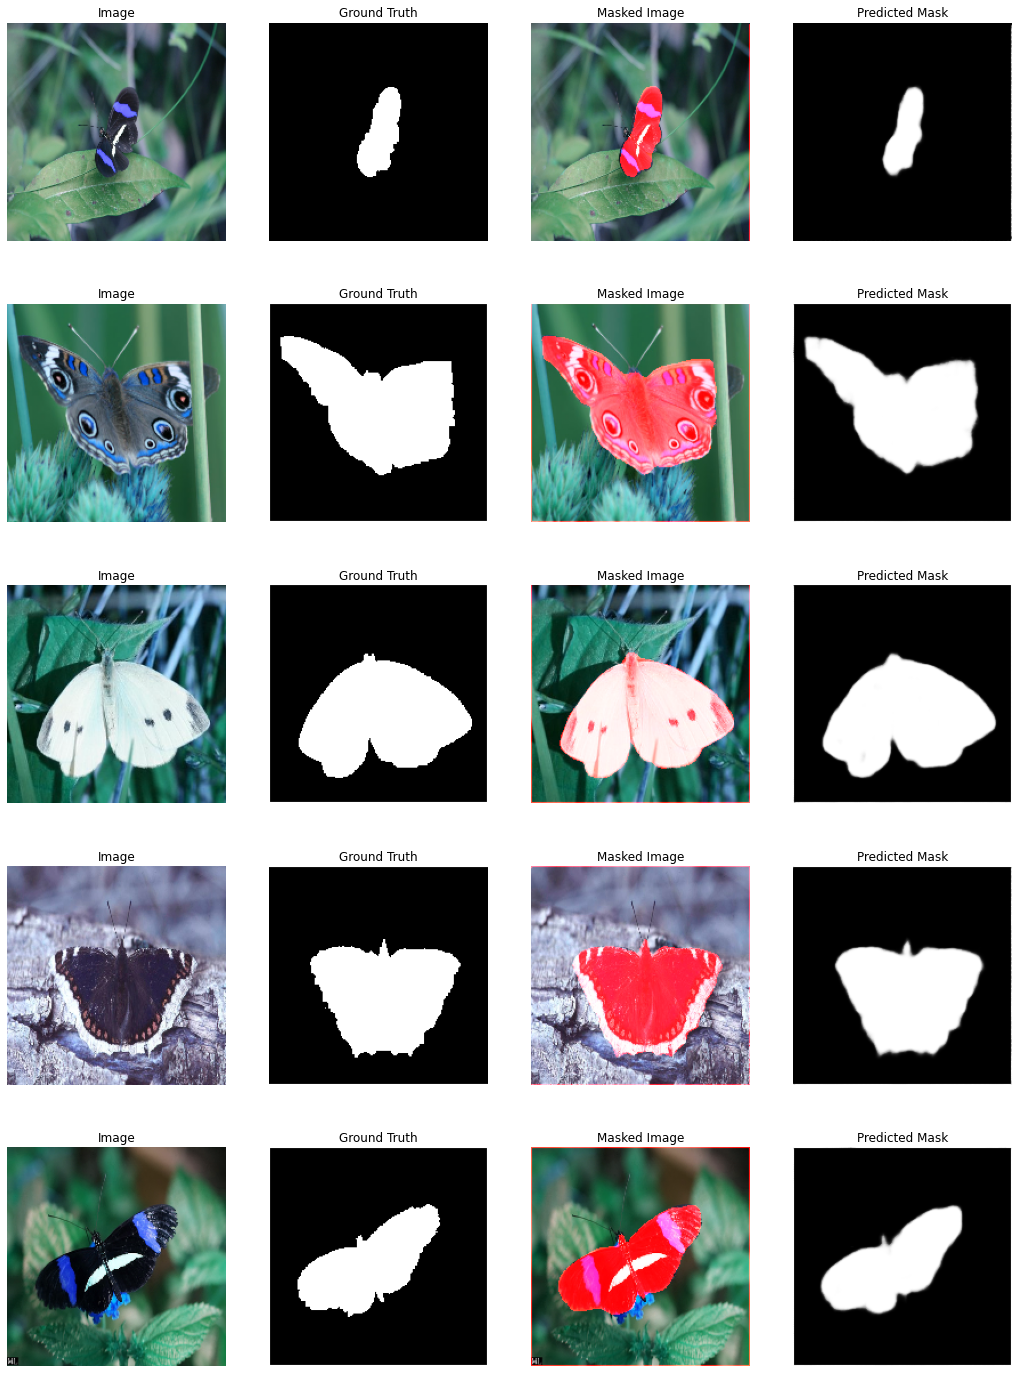

In [30]:
ind = np.random.randint(len(images),size=(5,))

fig,axes = plt.subplots(5,4,figsize=(18,25))

for i,(a0,a1,a2,a3) in zip(ind,axes):
    img,mask = images[i].copy(),masks_bin[i].copy()
    pred = model.predict(img.reshape(1,IMG_SIZE,IMG_SIZE,3)).reshape(IMG_SIZE,IMG_SIZE)
        
    masked = img.copy()
    box = masked[pred > 0.1].copy()
    box[:,0] = 1
    masked[pred > 0.1] = box
    
    a0.imshow(img)
    a0.set_title("Image")
    a0.axis("off")

    a1.imshow(mask.reshape(IMG_SIZE,IMG_SIZE),cmap="gray")
    a1.set_title("Ground Truth")
    a1.axis("off")

    
    a2.imshow(masked)
    a2.set_title("Masked Image")
    a2.axis("off")
     
    a3.imshow(pred,cmap="gray")
    a3.set_title("Predicted Mask")
    a3.axis("off")

In [31]:
fig.savefig("doc/conv_auto_encoder.png")

In [43]:
import pandas as pd

In [63]:
h0,h1,h2,h3 = hist

h0 = pd.DataFrame(h0.history)
h1 = pd.DataFrame(h1.history)
h2 = pd.DataFrame(h2.history)
h3 = pd.DataFrame(h3.history)

h0['batch_size'] = 8
h1['batch_size'] = 4
h2['batch_size'] = 2
h3['batch_size'] = 1

history = [h0,h1,h2,h3]

# history = pd.concat(history)
# history.to_csv("checkpoints/conv_enc_hist.csv")

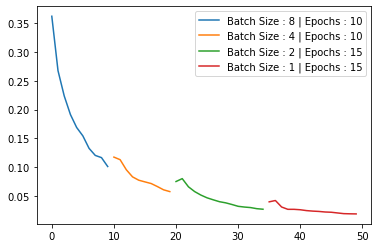

In [86]:
base = 0

for h,(b,e) in zip(history,grid):
    plt.plot(h.index + base,h.loss, label=f"Batch Size : {b} | Epochs : {e}")
    base += e
    
plt.legend()